# Using TensorFlow with big data: the complicated case of TFRecord

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/12bnTDGZB4Br_6AHcY3cfCtl_-5PQVY2j"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## A short walk-through to give a solution to the following problem 

Imagine this scenario. You are trying to train a big model on some big data you were given. The solution should be easy: just plug in a neural network like the one you saw during your Machine Learning with Big Data course, load your data and feed them to your model. Wait a few hours and you're done. You leave your laptop working, and go grab some lunch. Mic drop, job done.

<figure>
<center>
<img src='https://raw.githubusercontent.com/dpiras/TFrecord_workshop/main/job_done.png' />
</figure>


Except that when you come back from your lunch break you realise your model never started training, because there is not enough memory to store all that data at once. You try a few things, but there is a fundamental issue in the amount of memory that you are requiring, and you realise you won't be able to train your model that easily.

If you are lucky enough to work or study in a place that can give you extra resources, more powerful GPUs or unlimited credits on [AWS](https://aws.amazon.com/), then you might get away with it. However, even with, say, a bigger GPU, you might not be able to fit all of your data in memory, and big data centers have their own challenges: the interface might be in old, plain Linux, and the energy consumption has a [non-negligible environental impact](https://www.nature.com/articles/d41586-018-06610-y#:~:text=Data%20centres%20contribute%20around%200.3,than%202%25%20of%20global%20emissions.).

`TensorFlow` provides a way out, in the form of `TFRecord`. Through this utility, you can binarise your data, thus making them easier to read, write and store, leaving an overall smaller memory footprint. However, understanding and working with `TFRecord` can be a pain, due to lack of documentation and complicated jargon.

In this guide, we will try to give you an overview of the problem, as well as a practical way to make the most out of `TFRecord`, without worrying too much about the finer details. For those who are more keen, there is a list of resources at the end, which provide more insight about this niche tool, and from which we took inspiration in putting together this notebook.

For any additional information feel free to send an email to Davide Piras at d.piras@ucl.ac.uk

## Let's get hands-on 

### Training a CNN on MNIST

We first import some standard libraries. We will be working with `TensorFlow` (TF) 2.x, depending on which one is available on your machines.

TF2 is relatively recent, and is the newer version of TF. If you have only seen TF1, do not worry! There are [plenty of examples available](https://github.com/ageron/handson-ml2) to begin this journey.

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# print TF version
print(tf.__version__)

# this is to have easy access to TF datasets, for later on
import tensorflow_datasets as tfds
# this is an experimental feature in TF; we won't cover it here
# it's related to the choice of how to select batches of data during training
# in a memory efficient way
AUTOTUNE = tf.data.experimental.AUTOTUNE

2.4.1


The first goal will be downloading the MNIST dataset, the standard ML dataset containing 70000 images of labelled handwritten digits with size 28x28x1. You should already be quite familiar with it, but in case you want to read more, you can do so [here](https://en.wikipedia.org/wiki/MNIST_database).

In order to download and easily deal with the pure MNIST dataset, we use a couple of non-standard libraries and commands that can do the job for us (note that there are other options available for this, and we will explore some of them below). Commands starting with `!` are bash commands.

In [ ]:
! pip install python-mnist

In [ ]:
# the fist two lines used to work, but are currently failing due to a 503 error;
# ignore them for now, but they offer an alternative that will take a few minutes
# to download the dataset, depending on your internet connection and colab overall usage
#! cd ./python-mnist/
#! ./python-mnist/bin/mnist_get_data.sh

# these two commands currently work
! wget www.di.ens.fr/~lelarge/MNIST.tar.gz
! tar -zxvf MNIST.tar.gz

--2021-04-30 10:49:39--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-30 10:49:39--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [     <=>            ]  33.20M  37.5MB/s    in 0.9s    

2021-04-30 10:49:40 (37.5 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

We downloaded the MNIST dataset locally. It is good practice to explore it before playing with it, but we assume you are familiar with this dataset already. 

Out of curiosity, we want to print the size of the folder containing the dataset. Note that the folder contains also some other files, which we do not want to include in our calculation. Hint: there is a bash command to find the size of a folder and its files, and this is `du`. To explore the suggested solution, you can double click on the form. 

In [ ]:
# YOUR ANSWER HERE

In [ ]:
#@title Solution
# -s stands for summarise
# -h stands for human-readable
# -c prints the sum as well
! du -shc MNIST/raw/*ubyte

We collect training and testing images and labels, and execute a few operations for them to be ready to use.

In [ ]:
from mnist import MNIST
mndata = MNIST('./MNIST/raw')
images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [ ]:
images_train = np.array(images_train).reshape(-1, 28, 28, 1)
labels_train = np.array(labels_train)
images_test = np.array(images_test).reshape(-1, 28, 28, 1)
labels_test = np.array(labels_test)

(28, 28, 1)


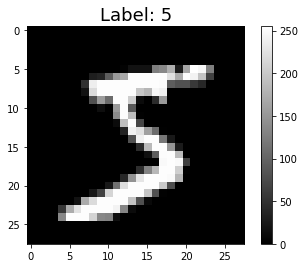

In [ ]:
# we have a look at the first image; it's not good practice to break a for loop
# but let's just ignore it in this case, as we will compare it to TFRecord
for image, label in zip(images_train, labels_train):
  print(image.shape)
  plt.imshow(image[:, :, 0], cmap='gray')
  plt.title(f'Label: {label}', fontsize=18)
  plt.colorbar()
  break

We then define a general model for classifying the digits in the dataset. This is the standard example of supervised learning, and you can refer to the lecture material for more information. Note that we use 2D convolutional layers, which should give us a better performance in terms of accuracy, but this is not essential for `TFRecord`, of course. Can you describe/sketch the neural network we are using for this classification task?

In [ ]:
def get_cnn():
  model = tf.keras.Sequential([
      
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[28,28, 1]),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
  ])

  model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

  return model

In [ ]:
model = get_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0

In [ ]:
# a few hyperparameters; feel free to play with them
batch_size = 128
epochs = 3

In [ ]:
# we fit our model and look at the performance on the test set as we progress through the training
# note we also take note of the total time to train the model
start = time.time()
model.fit(
    x = images_train, 
    y = labels_train,
    validation_data=(images_test, labels_test),
    epochs=epochs,
)
print(f'Total time to fit the model was {((time.time()-start))/60:.2f} minutes')

Epoch 1/3
1875/1875 [==============================] - 23s 4ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.8486 - val_loss: 0.0411 - val_sparse_categorical_accuracy: 0.9868
Epoch 2/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0392 - val_sparse_categorical_accuracy: 0.9872
Epoch 3/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0327 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.0280 - val_sparse_categorical_accuracy: 0.9913
Total time to fit the model was 0.60 minutes


Each epoch should take about 190 s, if not using any specific hardware accelerator. With a standard GPU, it took about 10 seconds/epoch - we recommend using one, to speed things up! 

In order to do so, you can simply click on `Runtime`, then `Change runtime type`, and choose your favourite one. Note though that on `colab` it is good practice to not use resources you do not really need, and the chances of being suspended for bad use of resources are quite high - trust us!

With a "high-ram" GPU, it takes roughly the same, while with a 'high-ram' TPU it took a bit more, but this will not be covered here.

Now, you might be happy - and you should be - as in no more than 10 minutes without GPU you got a 1% error rate on the test set. However, there are many cases, as explained above, where you need to allocate your memory in a more calibrated way, sometimes to avoid catastrophic failures.

### Training a CNN on MNIST using `TFRecord`

We download the official TF version of the MNIST dataset using `TensorFlow` itself.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


As you can see, the whole dataset, which was 53 MB, was downloaded to a folder on Colab. The dataset is stored already as `TFRecord` files. Let's explore it a bit.

In [ ]:
ds_train

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# look at this only after you've answered the first question above! 
! du -shc ../root/tensorflow_datasets/mnist/3.0.1/mnist*

3.2M	../root/tensorflow_datasets/mnist/3.0.1/mnist-test.tfrecord-00000-of-00001
19M	../root/tensorflow_datasets/mnist/3.0.1/mnist-train.tfrecord-00000-of-00001
23M	total


Taking inspiration from the code above, can you write a small `for` loop to show the first image and label in the training set? Note that both images and labels are stored in `ds_train`.

In [ ]:
# YOUR CODE HERE

In [ ]:
#@title Solution
for image, label in ds_train:
  print(image.numpy().shape)
  plt.imshow(image[:, :, 0], cmap='gray')
  plt.title(f'Label: {label.numpy()}', fontsize=18)
  plt.colorbar()
  break

The dataset is stored in a more criptic way: note, however, that it takes only 23 MB - less than half the previous case! One advanced thing to note, though, is that each pixel is stored as an `np.uint8` data type in this case, while it was a `np.int64` previously. This reduces the precision with which each pixel is stored, but it is not a problem in this case as all pixels can just take values between 0 and 255. Clearly, a lower precision number requires less memory to be stored!

To prepare this dataset for training, we need a few more steps.

In [ ]:
# this is 60000 for our dataset
training_set_size = ds_info.splits['train'].num_examples 

In [ ]:
# cache will improved speed when iterating over a dataset more than once
# e.g. after the first epoch
ds_train = ds_train.cache()
# we only shuffle the training set
ds_train = ds_train.shuffle(training_set_size)
# we tell TF that we will take data in batches
ds_train = ds_train.batch(batch_size)
# this last command is used for the following:
# "This allows later elements to be prepared while the current element is being processed. 
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements."
ds_train = ds_train.prefetch(AUTOTUNE)

# and we do the same for the test set
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(AUTOTUNE)

Then we are ready to train, just as above!

In [ ]:
model = get_cnn()

In [ ]:
start = time.time()
model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=epochs,
)
print(f'Total time to fit the model was {((time.time()-start))/60:.2f} minutes')

Epoch 1/3
469/469 [==============================] - 8s 8ms/step - loss: 2.1295 - sparse_categorical_accuracy: 0.6847 - val_loss: 0.0581 - val_sparse_categorical_accuracy: 0.9833
Epoch 2/3
469/469 [==============================] - 3s 6ms/step - loss: 0.0630 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9872
Epoch 3/3
469/469 [==============================] - 3s 6ms/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.0436 - val_sparse_categorical_accuracy: 0.9852
Total time to fit the model was 0.23 minutes


This should take about 170 s per epoch without hardware acceleration, and 3 s per epoch with a standard GPU. To recap: we used a ready-made `TFRecord` file that contains the MNIST dataset, and adapted it to train our model. We obtained a significant reduction in the size of the dataset, and only a marginal improvement in the speed, at the cost of a more complicated set of preprocessing steps. The accuracy does not seem to be significantly affected, as it should be.

### The concept behind `TFRecord`, and how to use it

Now we are going to do the same exercise, but this time we will create our own `TFRecord`. To show how to make your own `TFRecord` out of a dataset you have available (not necessarily MNIST), we will save it, and then re-load it from disk.

Remember that when downloading the dataset from `tfds`, it is stored as a `.tfrecord` file, with a total size of about 23 MB. This is already less than the original dataset, which is about 53 MB, as mentioned above, even though we should also keep in mind that the precision in the latter case is lower, so that everything is stored more efficiently .

We define a few functions that are needed to convert our dataset into a `TFRecord`. To give you an idea of what we are trying to do, instead of having some `.txt`, `.csv` or `.npy`* files scattered around and that we have to load in memory every time during our model training, forcing the disks to jump between blocks, we simply store the data in a sequential layout. We can visualize this concept in the following way:


<figure>
<center>
<img src='https://raw.githubusercontent.com/dpiras/TFrecord_workshop/main/TFRecord_1.png' />
</figure>

Every single data sample is called an `Example`, and is essentially a dictionary, storing the mapping between a key and our actual data - you should be able to grasp the concept if you are familiar with python dictionaries.

An additional complication comes when you want to write your data to a `TFRecord`, as you first have to convert your data to a `Feature`. These features are then the inner components of one `Example`:

<figure>
<center>
<img src='https://raw.githubusercontent.com/dpiras/TFrecord_workshop/main/TFRecord_2.png' />
</figure>



*`.npy` file are actually serialised files as well, and optimised for NumPy. If possible, try to use them! They occupy much less space and are faster to read/write using `numpy`.

Here we start by defining the mapping dictionary for our records.


In [ ]:
# the first three functions help distinguish between floats, ints
# or bytes/strings. We save that as a Feature
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # note we consider the numpy version of the array, so we are indeed
    # saving a numpy array, like the one you could have available
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# this is the function that actually serializes the array
# where the array could be an image, some text, or even an audio file
def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [ ]:
ds_splits = ["train", "test"]

# we have a for loop for each subset, i.e. for training and testing data
# we could even split our training data in multiple files, to avoid having one bigger file
# details on how to do this are in the resources at the end
for d in ds_splits:
  print("Saving {}".format(d))
  
  # there is a small catch here: since we want to compare the results with the TFRecord case,
  # we cast each pixel from np.int64 to np.uint8. Note that this reduces the memory requirements a bit.
  # There is a comment about this in the solutions below
  if d == 'train':
    subset = zip(np.uint8(images_train), labels_train)
  elif d == 'test':
    subset = zip(np.uint8(images_test), labels_test)
  else:
    raise ValueError('The split should be either "train" or "test"')

  filename = d+".tfrecords"
  
  # this is crucial: we define a Writer for the TFRecord, which we will use to create our TFRecord dataset
  # note that we can specify different compression types, either none (''), 'GZIP' or 'ZLIB'
  writer = tf.io.TFRecordWriter(filename, options=tf.io.TFRecordOptions(compression_type=''))
  count = 0
  for image, label in subset:
    # we need to specify the details of our images
    data={
        'height': _int64_feature(28),
        'width': _int64_feature(28),
        'depth': _int64_feature(1),
        'label': _int64_feature(label),
        'image_raw':_bytes_feature(serialize_array(image))
        }
        
    out = tf.train.Example(features=tf.train.Features(feature=data))
    writer.write(out.SerializeToString())
    count +=1
  writer.close()
  print(count)

Saving train
60000
Saving test
10000


 Note that our images are made of integers, and every pixel goes from 0 to 255. If we wanted to normalise our data and consider each pixel as a float, we would need to change our dictionary, of course! Note that we would also need to change `parse_tensor` below to use `tf.float64`, which would require more memory. We won't be covering this here, but feel free to try it for yourself.

We can check the size of our TFRecord by using the same command as above.

In [ ]:
! du -shc ./*.tfrecords

8.7M	./test.tfrecords
53M	./train.tfrecords
61M	total


What do you observe? What changes when you change the compression type?

In [ ]:
# YOUR ANSWER HERE

In [ ]:
#@title Solution
print('When not compressing the TFRecord, we obtain similar or bigger sizes as in the first case: this is because TFRecord _per se_ is not efficient at storing data. \nHowever, these files can be easily compressed, getting to as little as 12 MB! \nStill, note that the same compression type will have to be specified below, and in principle compression could slow loading and training down a bit. \nA more advanced note: if we had kept the np.int64 data type for the pixels, we would be using ~300 MB without compression, and ~19 MB with compression \nThis would still be better than both the given TFRecord file and the numpy array!')

We now focus our attention on reading back the `TFRecord` files, and load them back into memory. Note we need to specify a dictionary again, to explain to `TensorFlow` how to "read" the data and unserialise them.

In [ ]:
def parse_tfr_elem(element):
  # this is the dictionary needed to read the data back in
  # note each image is read back in as a string
  parse_dict = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'label':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'image_raw': tf.io.FixedLenFeature([], tf.string)
  }
  
  example_message = tf.io.parse_single_example(element, parse_dict)

  # we read each image in the TFRecord using this dictionary
  img_raw = example_message['image_raw']
  height = example_message['height']
  width = example_message['width']
  depth = example_message['depth']
  label = example_message['label']

  feature = tf.io.parse_tensor(img_raw, out_type=tf.uint8)
  feature = tf.reshape(feature, shape=[height,width,depth])
  return (feature, label)

In [ ]:
def get_dataset(filename, set_type):
    # you can ignore these first two lines
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable native order, increase speed

    # it is very important here to specify the same compression type as above
    # otherwise TF won't be able to read the data back in!
    dataset = tf.data.TFRecordDataset(filename, compression_type='')
    
    dataset = dataset.with_options(
        ignore_order
    )  

    # now, when we read back into memory, we explain TF how to read each element
    # 'map' is used to apply a function - in this case, parse_tfr_elem - to all the elements in dataset
    dataset = dataset.map(
        parse_tfr_elem, num_parallel_calls=AUTOTUNE
    )
    
    # now we can repeat the steps as above
    dataset = dataset.cache()
    dataset = dataset.shuffle(training_set_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    # the next command is needed to re-use the training set
    # note that if we do this, we also need to specify
    # steps_per_epoch=training_set_size//batch_size when calling model.fit!
    # the results are equivalent
    #dataset = dataset.repeat() if set_type =='train' else dataset 
    return dataset

With the two functions defined above, it is now easy to load the saved `TFRecord` files, which are ready to be fed into our model.

In [ ]:
tfr_dataset_train = get_dataset('train.tfrecords', 'train')
tfr_dataset_test = get_dataset('test.tfrecords', 'test')

In [ ]:
model = get_cnn()

Can you write the final cell to fit the model on the dataset just created? Hint: you need to specify `steps_per_epoch` in addition to what was done above.

In [ ]:
#@title Solution
start = time.time()
model.fit(tfr_dataset_train, epochs=epochs, validation_data=tfr_dataset_test)
print(f'Total time to fit the model with TFRecord was {((time.time()-start))/60:.2f} minutes')

You should get similar times as the second experiment above: all in all we are using the same methodology, and we just re-built our `TFRecord`!

## Conclusions

This notebook provides a hands-on solution for cases that happen often in real life: we have limited resources, and we need to carefully allocate memory, to store the data and train the model. As you could see, in this case the advantage was only marginal, hence `TFRecord` is not the solution to all problems, and it should be carefully designed and tested before spending too much time optimising it. In addition to that, you could observe how complicated things can get when we need to save a binary file, and the theory behind it is well beyond the scope of this short workshop. Feel free to draw more inspiration from the links posted below!

## Sources

[Official TFRecord documentation](https://www.tensorflow.org/tutorials/load_data/tfrecord)

[Tensorflow Records? What they are and how to use them](https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564)

[TFRecords Explained](https://towardsdatascience.com/tfrecords-explained-24b8f2133282)

[A practical guide to TFRecords](https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c)

[Using TFRecords to Train a CNN on MNIST](https://towardsdatascience.com/using-tfrecords-to-train-a-cnn-on-mnist-aec141d65e3d)

<figure>
<center>
<img src='https://raw.githubusercontent.com/dpiras/TFrecord_workshop/main/psst.jpg' />
</figure>